<a href="https://colab.research.google.com/github/jjeamin/kaggle/blob/master/Blood_Cell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU 사용하기 [먼저해야함!!]
- 상단 바에 런타임 클릭
- 런타임 유형변경 클릭
- GPU 선택

In [2]:
!pwd

/content


# Datasets Download

- [https://www.kaggle.com/paultimothymooney/blood-cells/kernels](https://www.kaggle.com/paultimothymooney/blood-cells/kernels) 접속

- Download 버튼 클릭 -> Download
- 왼쪽 업로드 버튼 클릭 -> Download 한 압축파일 선택
- `content/` 폴더에 압축파일 Drag and Drop

In [3]:
!unzip blood-cells.zip

Archive:  blood-cells.zip
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00000.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00001.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00002.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00003.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00004.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00005.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00006.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00007.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00008.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00009.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00010.xml  
  inflating: dataset-master/dataset-master/Annotations/BloodImage_00011.xml  
  inflating: dataset-master/dataset-ma

# DataSets

## 용어
- RBC : Red Blood Cell
- WBC : White Blood Cell

- NEUTROPHIL : 호중구
- EOSINOPHIL : 호산구
- MONOCYTE : 단핵구
- LYMPHOCYTE : 림프구

---

## 파일구조 살펴보기

### //dataset-master1

- dataset-master1 폴더에는 Annotations, JPEGImages 폴더가 2개 있다. Annotations 에는 xml파일이 있다. 아마 bounding box로 물체를 검출하는데 사용할 데이터셋으로 판단된다.

- xml 파일을 살펴볼때 RBC에 대한 bounding box만 존재한다. WBC가 없는 것을 보아 object detection 데이터셋이 조금 이상한 것 같다.

- 만약 object detection을 진행하려면 [이 곳](https://github.com/Shenggan/BCCD_Dataset/tree/master/BCCD)에서 데이터를 다시 받아야 한다.

### //dataset-master2

dataset-master2 폴더에는 이미지가 각 클래스 별로 폴더에 나누어져 있다. 그러므로 이미지를 분류하는 문제에서 사용할 데이터셋으로 판단된다. **실습은 분류문제를 해결하기 위해서 진행한다.**

In [0]:
import numpy as np
import os
import cv2
import math
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler

In [0]:
img_path = './dataset2-master/dataset2-master/images'

In [238]:
os.listdir(img_path)

['TRAIN', 'TEST_SIMPLE', 'TEST']

In [0]:
train_img_path = os.path.join(img_path, 'TRAIN')
test_img_path = os.path.join(img_path, 'TEST')
test_simple_img_path = os.path.join(img_path,'TEST_SIMPLE')

In [240]:
classes = os.listdir(train_img_path)
print('classes : ', classes)

classes :  ['LYMPHOCYTE', 'EOSINOPHIL', 'NEUTROPHIL', 'MONOCYTE']


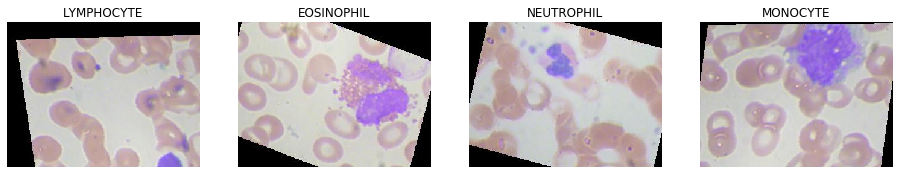

In [241]:
plt.figure(figsize=(20,20))

for i,cls in enumerate(classes):
    plt.subplot(1, 5, i+1)
    plt.title(cls)
    plt.axis('off')
    
    path=os.path.join(train_img_path, cls)
    img_path=os.listdir(path)[0]
    img = cv2.imread(os.path.join(path, img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.imshow(img)

# Hyperparameter

In [0]:
image_shape=[128,128,3]
batch_size=64
epochs=100

# Model

In [0]:
"""
model reference : https://www.kaggle.com/drobchak1988/blood-cell-images-acc-92-val-acc-90
"""
from keras.layers import Input, Activation, Dense, Conv2D, Reshape, concatenate, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D


bnmomemtum=0.85
def fire(x, squeeze, expand):
    y  = Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y  = BatchNormalization(momentum=bnmomemtum)(y)
    y1 = Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = BatchNormalization(momentum=bnmomemtum)(y3)
    return concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda x: fire(x, squeeze, expand)

x = Input(shape=image_shape)
y = BatchNormalization(center=True, scale=False)(x)
y = Activation('relu')(y)
y = Conv2D(kernel_size=5, filters=12, padding='same', use_bias=True, activation='relu')(x)
y = BatchNormalization(momentum=bnmomemtum)(y)

y = fire_module(12, 24)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(32, 64)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(24, 48)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(18, 36)(y)
y = MaxPooling2D(pool_size=2)(y)

y = fire_module(12, 24)(y)

y = GlobalAveragePooling2D()(y)
y = Dense(4, activation='softmax')(y)

In [244]:
from keras.models import Model

model = Model(x, y)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 12) 912         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 128, 128, 12) 48          conv2d_77[0][0]                  
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 128, 128, 12) 156         batch_normalization_82[0][0]     
____________________________________________________________________________________________

In [0]:
adam = Adam(lr=lr, decay=0.0001)

model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
train_generator = ImageDataGenerator(
        rescale=1./255,
)

test_generator = ImageDataGenerator(
        rescale=1./255,
)

In [247]:
train_data = train_generator.flow_from_directory(train_img_path,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 target_size=(image_shape[0], image_shape[1]),
                                                 shuffle=True,
                                                 class_mode = "categorical")

test_data = test_generator.flow_from_directory(test_img_path,
                                                color_mode='rgb',
                                                batch_size=batch_size,
                                                target_size=(image_shape[0], image_shape[1]),
                                                shuffle=True,
                                                class_mode = "categorical")

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [0]:
def step_decay(epoch):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 10.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

lrate=LearningRateScheduler(step_decay)

# Train

In [52]:
history = model.fit_generator(train_data, 
                              steps_per_epoch=train_data.n // train_data.batch_size, 
                              epochs=epochs, 
                              validation_data=test_data,
                              validation_steps=test_data.n // test_data.batch_size,
                              callbacks=[lrate])

Epoch 1/100
155/155 [==============================] - 21s 138ms/step - loss: 1.0299 - acc: 0.5195 - val_loss: 1.4582 - val_acc: 0.5193
Epoch 2/100
155/155 [==============================] - 16s 102ms/step - loss: 0.5496 - acc: 0.7443 - val_loss: 0.8472 - val_acc: 0.7858
Epoch 3/100
155/155 [==============================] - 16s 104ms/step - loss: 0.2813 - acc: 0.8864 - val_loss: 3.4928 - val_acc: 0.4787
Epoch 4/100
155/155 [==============================] - 16s 103ms/step - loss: 0.2456 - acc: 0.9057 - val_loss: 2.8945 - val_acc: 0.5353
Epoch 5/100
155/155 [==============================] - 16s 103ms/step - loss: 0.2121 - acc: 0.9178 - val_loss: 0.1531 - val_acc: 0.9303
Epoch 6/100
155/155 [==============================] - 16s 101ms/step - loss: 0.1719 - acc: 0.9377 - val_loss: 0.8685 - val_acc: 0.8159
Epoch 7/100
155/155 [==============================] - 15s 99ms/step - loss: 0.1603 - acc: 0.9383 - val_loss: 9.2976 - val_acc: 0.3141
Epoch 8/100
155/155 [============================

# Graph

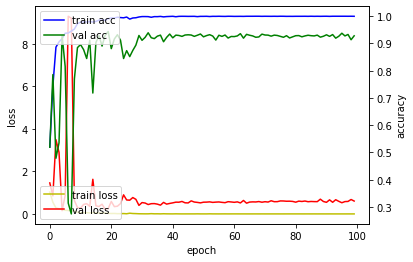

In [58]:
import matplotlib.pyplot as plt

fig, loss = plt.subplots()
acc = loss.twinx()

loss.plot(history.history['loss'], 'y', label='train loss')
loss.plot(history.history['val_loss'], 'r', label='val loss')
loss.set_xlabel('epoch')
loss.set_ylabel('loss')
loss.legend(loc='lower left')

acc.plot(history.history['acc'], 'b', label='train acc')
acc.plot(history.history['val_acc'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='upper left')

plt.show()

# Test

In [218]:
model.evaluate_generator(test_data, steps=test_data.n // test_data.batch_size)

[0.5967060221653235, 0.9276315789473685]

In [0]:
model.save_weights("model.h5")

In [0]:
model.load_weights("model.h5")

# Explainable Deep Learning
- CAM(Class Activation Mapping)

# reference

- [https://github.com/jacobgil/keras-cam](https://github.com/jacobgil/keras-cam)

In [0]:
class_weights = model.layers[-1].get_weights()[0]
layer_dict = dict([(layer.name, layer) for layer in model.layers])

In [251]:
layer_dict

{'batch_normalization_100': <keras.layers.normalization.BatchNormalization at 0x7f2f37ac0b70>,
 'batch_normalization_82': <keras.layers.normalization.BatchNormalization at 0x7f2f38d47588>,
 'batch_normalization_83': <keras.layers.normalization.BatchNormalization at 0x7f2f38d3bef0>,
 'batch_normalization_84': <keras.layers.normalization.BatchNormalization at 0x7f2f38d04ef0>,
 'batch_normalization_85': <keras.layers.normalization.BatchNormalization at 0x7f2f38c4bef0>,
 'batch_normalization_86': <keras.layers.normalization.BatchNormalization at 0x7f2f38c21320>,
 'batch_normalization_87': <keras.layers.normalization.BatchNormalization at 0x7f2f37e5f630>,
 'batch_normalization_88': <keras.layers.normalization.BatchNormalization at 0x7f2f37e23748>,
 'batch_normalization_89': <keras.layers.normalization.BatchNormalization at 0x7f2f37df3c18>,
 'batch_normalization_90': <keras.layers.normalization.BatchNormalization at 0x7f2f37db3e48>,
 'batch_normalization_91': <keras.layers.normalization.Batc

In [0]:
final_conv = layer_dict['concatenate_30']

In [0]:
import keras.backend as K

get_output = K.function([model.layers[0].input], [final_conv.output, model.layers[-1].output])

In [0]:
img_path = os.path.join(test_simple_img_path ,'LYMPHOCYTE//_5_1558.jpeg')

In [0]:
img = cv2.imread(img_path, 1)
img = cv2.resize(img, (128, 128))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

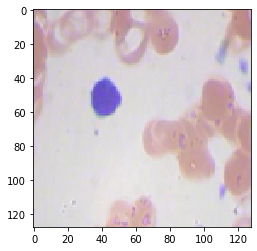

In [259]:
plt.imshow(img)

In [0]:
[conv_outputs, predictions] = get_output([[img]])

In [0]:
conv_outputs = conv_outputs[0, ...]
conv_outputs = np.transpose(np.float32(conv_outputs), (2,0,1))

In [0]:
cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])

In [0]:
for i, w in enumerate(class_weights[:, 1]):
    cam += w * conv_outputs[i, :, :]

In [0]:
cam /= np.max(cam)

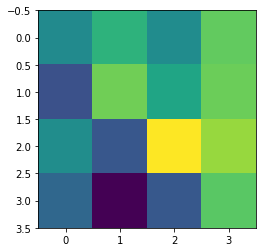

In [265]:
plt.imshow(cam)

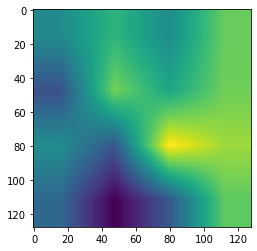

In [266]:
cam = cv2.resize(cam, (128, 128))
plt.imshow(cam)

In [267]:
heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
heatmap[np.where(cam < 0.2)] = 0
img = heatmap*0.5 + img
cv2.imwrite('./cam.jpg', img)

True

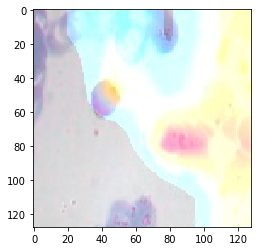

In [268]:
cam_img = cv2.imread('./cam.jpg')
cam_img = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGB)
plt.imshow(cam_img)